# Forecasting

## Deel 1: Sunspots

De dataset van zonnevlekken (sunspots) is een historische tijdreeks van het aantal waargenomen zonnevlekken op de zon. Zonnevlekken zijn tijdelijke verschijnselen op de zon die koeler zijn dan de omliggende gebieden en intense magnetische activiteit vertonen. Ze zijn zichtbaar als donkere vlekken op het zonneoppervlak. Het aantal zonnevlekken is een indicator van de zonneactiviteit en varieert met de zonnevlekkencyclus, die ongeveer elke 11 jaar plaatsvindt.

Wetenschappers hebben het aantal zonnevlekken systematisch bijgehouden sinds ongeveer 1610, na de uitvinding van de telescoop. Deze dataset wordt vaak gebruikt voor onderzoek naar zonneactiviteit en voor het testen van statistische modellen in tijdreeksanalyse. De dataset kan worden gebruikt om patronen en cycli in zonneactiviteit te identificeren en te voorspellen, zoals de ongeveer 11-jarige cyclus van zonneactiviteit bekend als de zonnevlekkencyclus.

In de context van statistische en voorspellende modellering, zoals in tijdreeksanalyse of autoregressieve modellen, wordt de zonnevlekken dataset vaak gebruikt als een benchmark om modellen te ontwikkelen en te testen die in staat zijn om seizoensgebonden patronen en lange termijn trends te identificeren. Het is een klassiek voorbeeld van een niet-stationaire tijdreeks die zowel seizoensgebonden als cyclische componenten bevat.

### Voorbereiding

In [63]:
# inlezen libraries

In [64]:
%matplotlib inline
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

In [65]:
# inlezen data

In [66]:
df = pd.read_csv('../DATA/Sunspots.csv')
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [67]:
# formaat van Date opvragen
df.dtypes

Unnamed: 0                             int64
Date                                  object
Monthly Mean Total Sunspot Number    float64
dtype: object

In [68]:
# Date is een object, we moeten dit omzetten naar een datum
df['Date'] = pd.to_datetime(df['Date'])
# Check omzetting: opnieuw formaat van Date opvragen
df.dtypes

Unnamed: 0                                    int64
Date                                 datetime64[ns]
Monthly Mean Total Sunspot Number           float64
dtype: object

In [69]:
# Date column als nieuwe index zetten:
df = df.set_index('Date')

In [70]:
# instellen van de maandelijkse frequentie van de dataset
df.index.freq = 'M'

In [71]:
df.index

DatetimeIndex(['1749-01-31', '1749-02-28', '1749-03-31', '1749-04-30',
               '1749-05-31', '1749-06-30', '1749-07-31', '1749-08-31',
               '1749-09-30', '1749-10-31',
               ...
               '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
               '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
               '2018-06-30', '2018-07-31'],
              dtype='datetime64[ns]', name='Date', length=3235, freq='M')

In [72]:
# De kolom Unnamed is niet echt relevant: verwijderen...
df = df.drop("Unnamed: 0",axis=1)

### Ontbrekende waarden?

In [73]:
# Zijn er ontbrekende waarden?
print(df.isna().sum())

Monthly Mean Total Sunspot Number    0
dtype: int64


In [74]:
df.describe()

,Monthly Mean Total Sunspot Number
count,3235.000000
mean,82.481082
std,67.805190
min,0.000000
25%,24.750000
50%,68.300000
75%,122.900000
max,398.200000


Er zijn dus nulwaarden (min = 0).  Aan de hand van het gemiddelde (ong 82) en de standaardafwijking (ong 68) zouden we kunnen
stellen dat nulwaarden te verwachten zijn.

### Uitschieters?

In [75]:
# Zijn er waarden die meer dan 5 standaardafwijkingen van het gemiddelde gelegen zijn?
from scipy import stats
z = np.abs(stats.zscore(df))
print(np.where(z > 5))

(array([], dtype=int64), array([], dtype=int64))


Er zijn dus geen uitschieters die meer dan 5 standaardafwijkingen van het gemiddelde af liggen.

### Visualiseren van de data

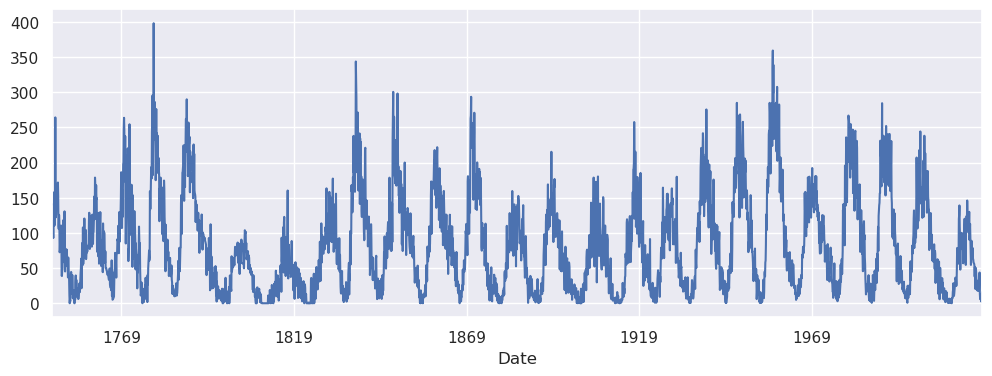

In [76]:
# eenvoudige plot van de data:
df['Monthly Mean Total Sunspot Number'].plot(figsize=(12,4));

Op het eerste gezicht lijkt het alsof er geen trend aanwezig is, maar er is wel een terugkerend patroon (een cyclus)

## Ontbinding van de tijdreeks in haar samenstellende componenten

In [77]:
# ets decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

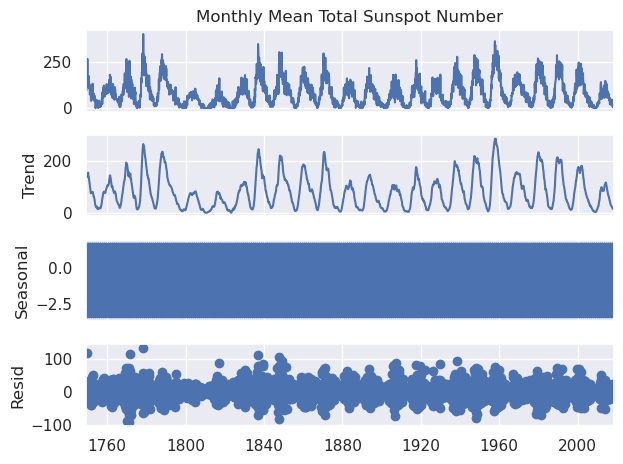

In [78]:
result = seasonal_decompose(df['Monthly Mean Total Sunspot Number'])
result.plot();

Bespreking bovenstaande grafieken:

We zien hier een decompositie van de totale tijdreeks zoals in de bovenstaande grafiek wordt weergegeven.  

De 3 componenten zijn:

-Trend: op het zicht is er een constante trend met additieve seasonaliteit.  We voeren zo dadelijk nog een bijkomende test uit om na te gaan of de tijdreeks stationair is: Dickey Fuller.  

-Seasonal: uit de grafiek voor seasonal kunnen we weinig meer opmaken dan dat er effectief een seasonal component aanwezig is, maar de schaal waarop deze zich manifesteert lijkt niet groot.  Dit is verder te bekijken door even in te zoomen op deze component.

-Residual: we zien geen geen versterkend of verzwakkend effect.  De residuals lijkt dus normaal.  We vergroten deze verderop even om dit meer in detail te bekijken.

### Stationair of niet?

In [79]:
# Verder onderzoek om te bevestigen dat de tijdreeks stationair is:
from statsmodels.tsa.stattools import adfuller

adfuller(df['Monthly Mean Total Sunspot Number'].dropna(),autolag='AIC')

(-10.492561501904923,
 1.137033189011858e-18,
 28,
 3206,
 {'1%': -3.4323913423381103,
  '5%': -2.862441941529731,
  '10%': -2.567250123571329},
 29585.347507175673)

Resultaat Dickey Fuller: de p-value is kleiner dan 0.05 (1.1370331890118824e-18) dus we kunnen de nulpypothese van de test verwerpen en stellen dat de tijdreeks stationair is.

### Seasonal component

<Axes: xlabel='Date'>

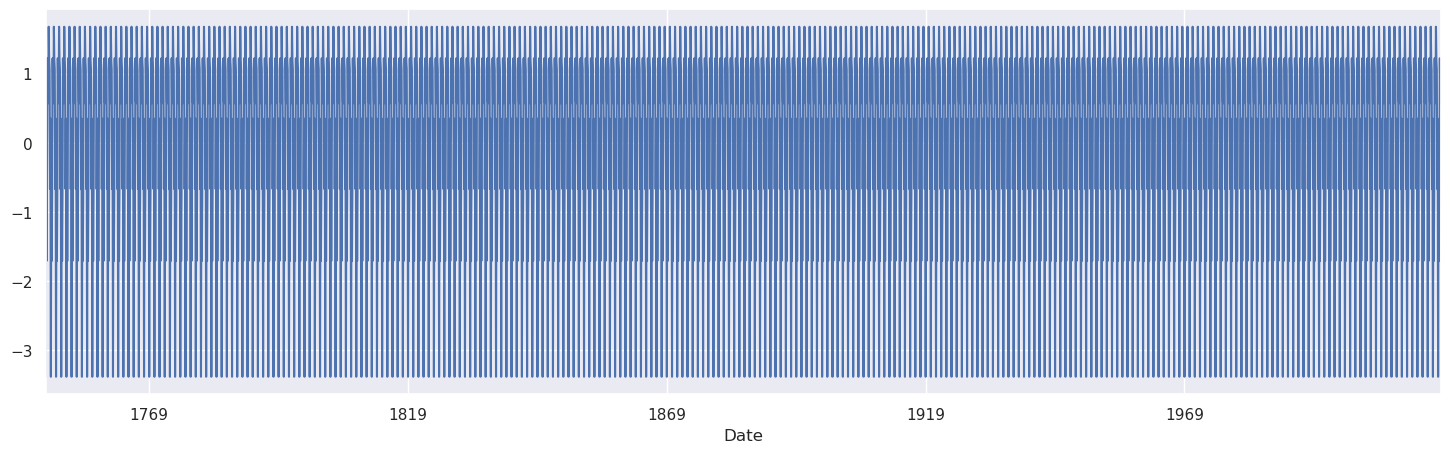

In [80]:
# seasonal component - we zoomen even in:
result.seasonal.plot(figsize=(18,5))

<Axes: xlabel='Date'>

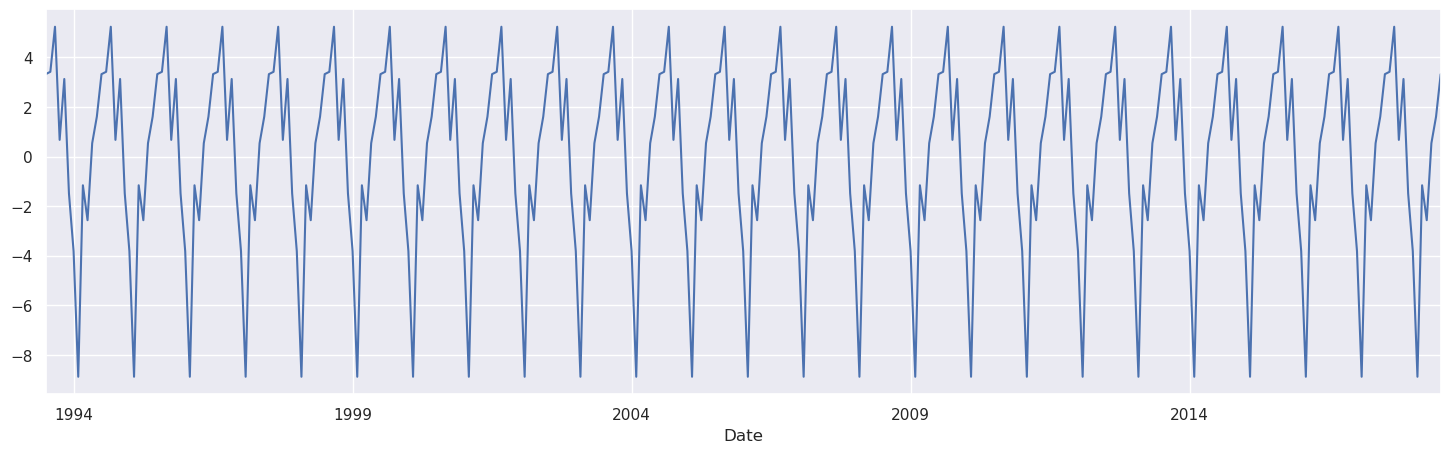

In [81]:
# Verder inzoomen op de seasonal plot van de laatste 25 jaar:
result = seasonal_decompose(df['Monthly Mean Total Sunspot Number'].loc['1993-07-31':])
# sterke seasonal component!! We zoomen even in op deze component:
result.seasonal.plot(figsize=(18,5))

### Residuals

<Axes: xlabel='Date'>

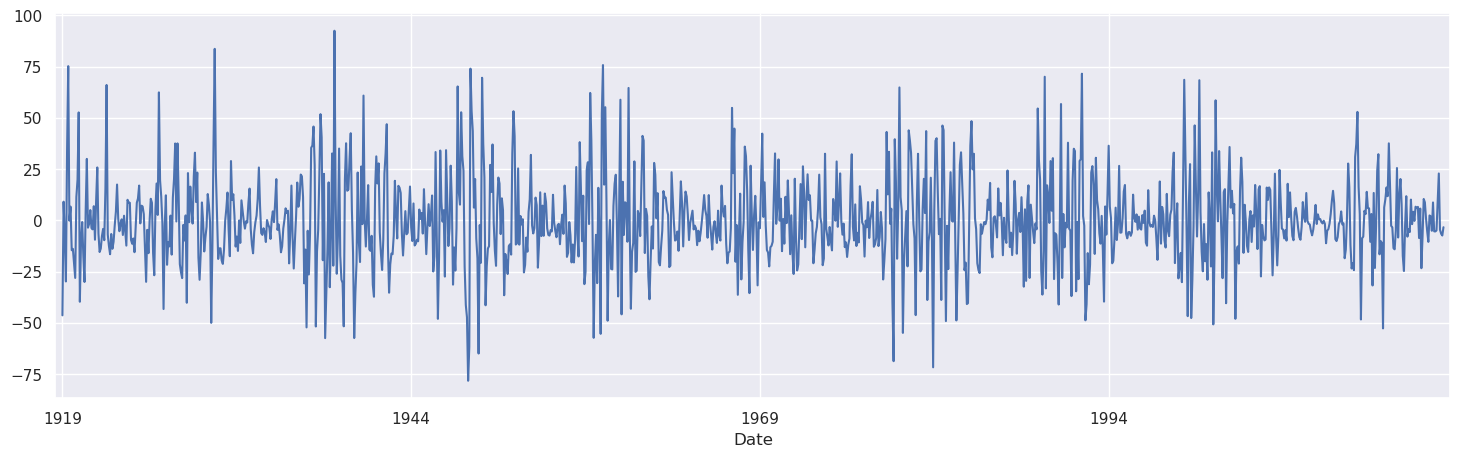

In [82]:
# Detail van de residual plot:
# Inzoomen op de seasonal plot van de laatste 100 jaar:
result = seasonal_decompose(df['Monthly Mean Total Sunspot Number'].loc['1918-07-31':])
result.resid.plot(figsize=(18,5))

## Simple moving average

<Axes: xlabel='Date'>

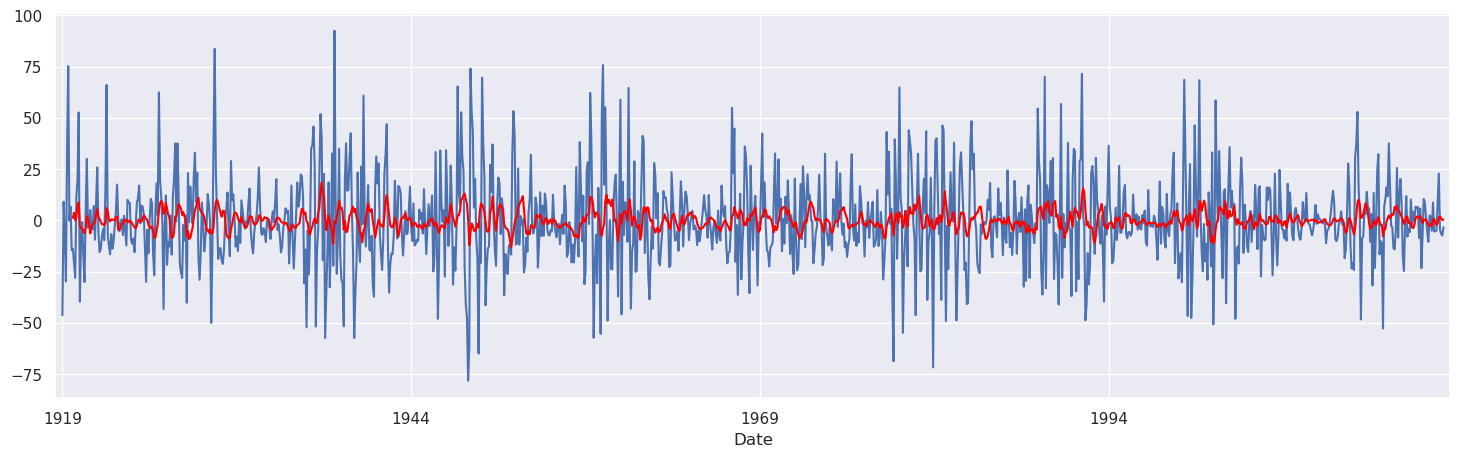

In [83]:
# Detail van de residual plot:
# Inzoomen op de seasonal plot van de laatste 100 jaar:
result = seasonal_decompose(df['Monthly Mean Total Sunspot Number'].loc['1918-07-31':])
result.resid.plot(figsize=(18,5))
result.resid.rolling(window=10).mean().plot(figsize=(18,5), color='red')

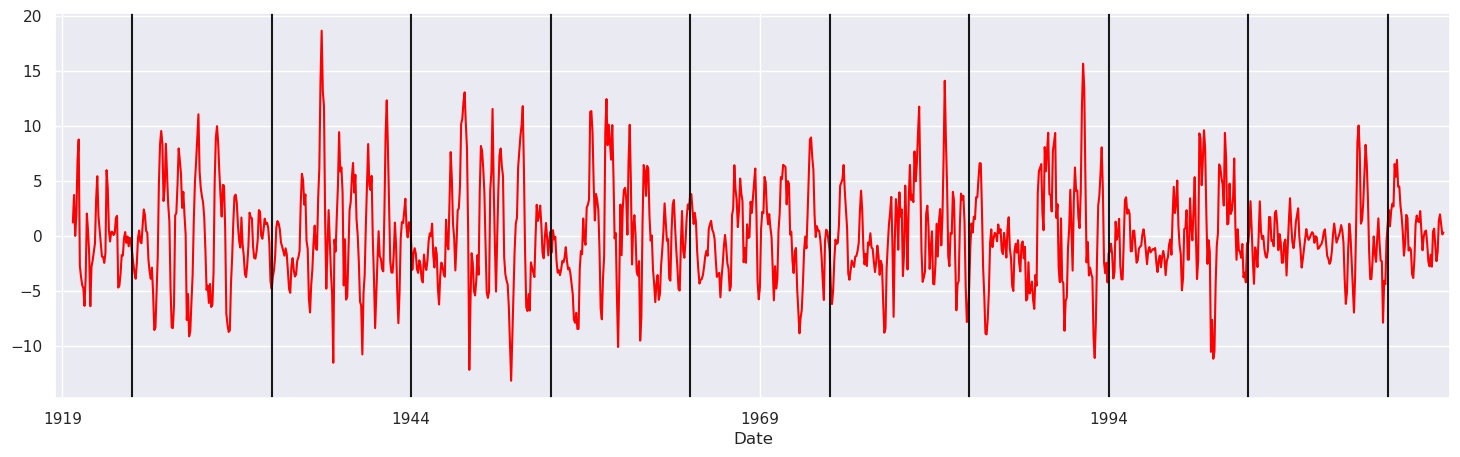

In [84]:
# enkel moving average van de residual plot:
ax = result.resid.rolling(window=10).mean().plot(figsize=(18,5), color='red')
ax.axvline(x='1924-01-01',color='black',alpha=0.9);
ax.axvline(x='1934-01-01',color='black',alpha=0.9);
ax.axvline(x='1944-01-01',color='black',alpha=0.9);
ax.axvline(x='1954-01-01',color='black',alpha=0.9);
ax.axvline(x='1964-01-01',color='black',alpha=0.9);
ax.axvline(x='1974-01-01',color='black',alpha=0.9);
ax.axvline(x='1984-01-01',color='black',alpha=0.9);
ax.axvline(x='1994-01-01',color='black',alpha=0.9);
ax.axvline(x='2004-01-01',color='black',alpha=0.9);
ax.axvline(x='2014-01-01',color='black',alpha=0.9);

In [85]:
train = df.loc[:'2009-07-31']
test = df.loc['2009-08-01':]

In [86]:
# Voortschrijdend gemiddelde als kolom in het dataframe toevoegen
df['Sunspot Rolling Mean 5'] = train['Monthly Mean Total Sunspot Number'].rolling(window=5).mean()
df['Sunspot Rolling Mean 10'] = train['Monthly Mean Total Sunspot Number'].rolling(window=10).mean()

# Voorspelling toevoegen: Sunspot rolling means 108 posities opschuiven (108 maanden = 9 jaar)
df['Rolling Mean 5 PRED'] = df['Sunspot Rolling Mean 5'].shift(108)
df['Rolling Mean 10 PRED'] = df['Sunspot Rolling Mean 10'].shift(108)

In [87]:
df.head(12)   # Vanaf rij 5 wordt moving average over 5m toegevoegd, vanaf rij 10 moving average over 10m.

,Monthly Mean Total Sunspot Number,Sunspot Rolling Mean 5,Sunspot Rolling Mean 10,Rolling Mean 5 PRED,Rolling Mean 10 PRED
Date,,,,,
1749-01-31,96.7,NaN,NaN,NaN,NaN
1749-02-28,104.3,NaN,NaN,NaN,NaN
1749-03-31,116.7,NaN,NaN,NaN,NaN
1749-04-30,92.8,NaN,NaN,NaN,NaN
1749-05-31,141.7,110.44,NaN,NaN,NaN
1749-06-30,139.2,118.94,NaN,NaN,NaN
1749-07-31,158.0,129.68,NaN,NaN,NaN
1749-08-31,110.5,128.44,NaN,NaN,NaN
1749-09-30,126.5,135.18,NaN,NaN,NaN


In [88]:
df.iloc[108:120, :]   # Vanaf rij 113 (108 + 5) wordt moving average over 5j van 132 periodes geleden toegevoegd.

,Monthly Mean Total Sunspot Number,Sunspot Rolling Mean 5,Sunspot Rolling Mean 10,Rolling Mean 5 PRED,Rolling Mean 10 PRED
Date,,,,,
1758-01-31,62.7,69.34,60.87,NaN,NaN
1758-02-28,86.7,73.44,64.54,NaN,NaN
1758-03-31,81.7,78.94,66.36,NaN,NaN
1758-04-30,120.5,81.48,76.28,NaN,NaN
1758-05-31,77.3,85.78,79.84,110.44,NaN
1758-06-30,75.0,88.24,78.79,118.94,NaN
1758-07-31,73.3,85.56,79.50,129.68,NaN
1758-08-31,64.5,82.12,80.53,128.44,NaN
1758-09-30,104.2,78.86,80.17,135.18,NaN


In [89]:
# Import evaluatie metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error   # Deze functies vergelijken actuals (1e parameter) met voorspellingen (2e parameter)

In [90]:
mean_absolute_error(test['Monthly Mean Total Sunspot Number'], df['Rolling Mean 5 PRED'].loc['2009-08-01':])

56.42796296296296

In [91]:
mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['Rolling Mean 5 PRED'].loc['2009-08-01':])

5708.936737037037

In [92]:
rmse = mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['Rolling Mean 5 PRED'].loc['2009-08-01':], squared=False)
rmse
# Alternatief: manuele berekening vanuit MSE
# np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['Rolling Mean 5 PRED'].loc['2009-08-01':])) # rmse

75.55750615946134

In [93]:
# Genormaliseerde RMSE:
rmse / ( df['Monthly Mean Total Sunspot Number'].max() - df['Monthly Mean Total Sunspot Number'].min() )

0.18974762973244938

## EWMA: Exponentially Weighted Moving Average

##### Syntax df.ewm
df['column_name'].ewm(span=12,adjust=False).mean()
<ol>span = aantal periodes waarover moving average berekend wordt
    <ol>indien span opgegeven -> &alpha; = 2 / ( span + 1 ) </ol></ol>
<ol>adjust = berekeningswijze eerste periodes (waar periode < span)
    <ol>True = formule wordt toegepast op periodes voor zover beschikbaar; m.a.w. 1e periode = actuele waarde ; voor 2e periode is max. gewicht = (1 - &alpha; ) ; voor 3de periode is max. gewicht = (1 - &alpha; )<sup>2</sup> ; etc. </ol>
    <ol>False = recursieve berekening, o.b.v. huidige periode + moving average van vorige periode </ol>

In [94]:
df['EWMA12'] = train['Monthly Mean Total Sunspot Number'].ewm(span=12,adjust=True).mean()

# Voorspelling toevoegen: Sunspot rolling means 132 posities opschuiven (132 maanden = 11 jaar)
df['EWMA PRED'] = df['EWMA12'].shift(132)

In [95]:
mean_absolute_error(test['Monthly Mean Total Sunspot Number'], df['EWMA PRED'].loc['2009-08-01':])

47.29057218187267

In [96]:
mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['EWMA PRED'].loc['2009-08-01':])

3614.2654077148914

In [97]:
rmse = mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['EWMA PRED'].loc['2009-08-01':], squared=False) # rmse
rmse

60.11876086310239

In [98]:
# Genormaliseerde RMSE:
rmse / ( df['Monthly Mean Total Sunspot Number'].max() - df['Monthly Mean Total Sunspot Number'].min() )

0.1509762954874495

<Axes: xlabel='Date'>

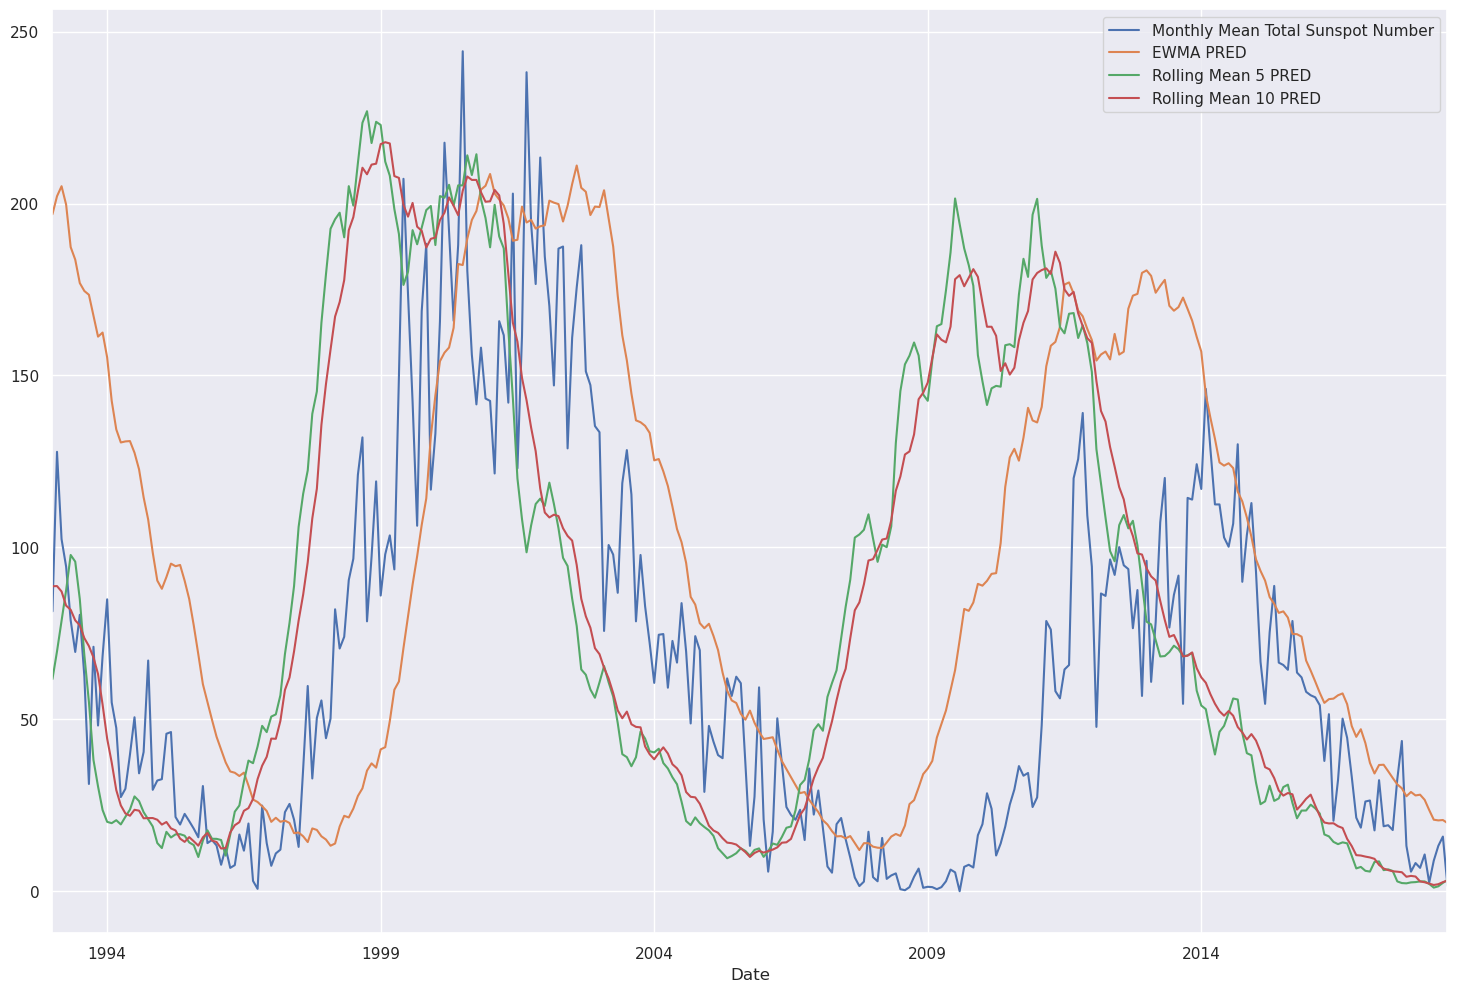

In [99]:
# plot van een detail van de laatste 25 jaar:
# df[['Monthly Mean Total Sunspot Number','TES120_predictions', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED', 'AR PRED']].loc['1993-01-01':].plot(figsize=(18,12), legend='True')
df[['Monthly Mean Total Sunspot Number', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED']].loc['1993-01-01':].plot(figsize=(18,12), legend='True')

<Axes: xlabel='Date'>

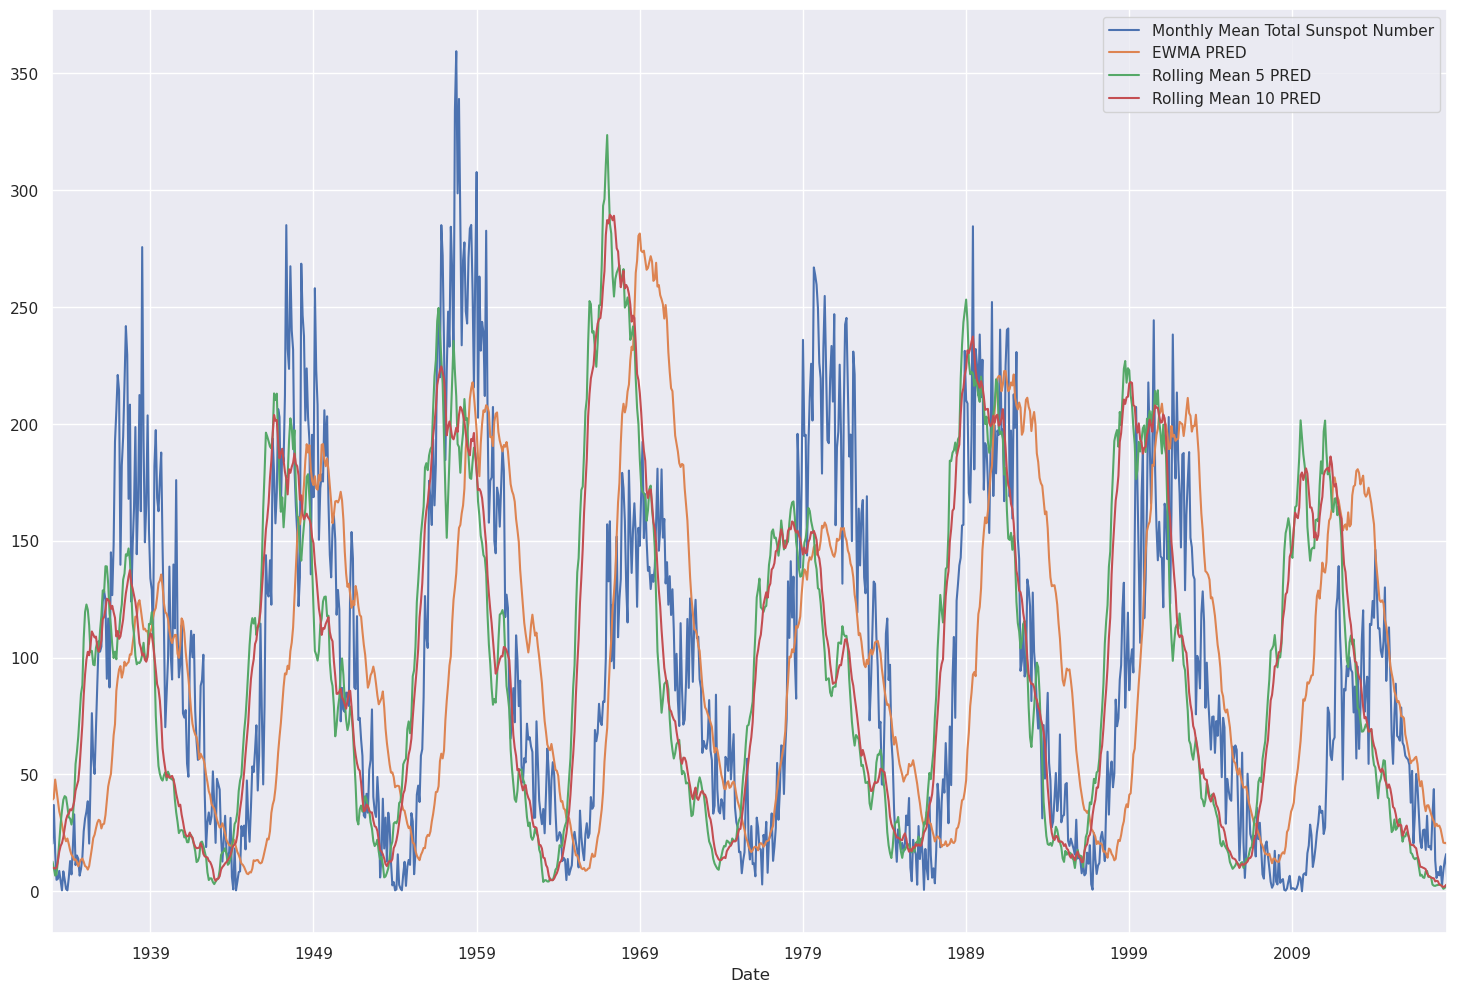

In [100]:
# df[['Monthly Mean Total Sunspot Number','TES120_predictions', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED']].loc['1933-01-01':].plot(figsize=(18,12), legend='True')
df[['Monthly Mean Total Sunspot Number', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED']].loc['1933-01-01':].plot(figsize=(18,12), legend='True')

Wanneer we dezelfde plot over een langere periode nemen wordt duidelijk dat er rond 1959 een grote piek was.  De impact hiervan is te zien in de volgende voorspelling rond 1969: de voorspelling is veel hoger dan de werkelijke piek en is dus een overschatting.  De voorspelling wordt namelijk berekend op basis van de voorgaande gegevens.  Bij EWMA krijgen de laatste gegevens een hoger gewicht dan 'oudere' data.  Niet alleen de hoogte van de piek wordt bepaald door de voorgaande data, maar ook de frequentie.  De voorspelling begint dus te stijgen ifv wat de data in de daarvoor gelegen periode deed.  De piek rond 1969 was lager en breder (duurde dus langer), met als effect dat de volgende voorspelde piek (rond 1980) te laag werd voorspeld en te vroeg begon.  Aangezien de piek langer duurde, is de daaropvolgende piek (begin jaren 90) opnieuw min of meer in sync.

## Autocorrelatie 
Op basis van meteo data: wat is autocorrelatie en welke informatie haal je uit de autocorrelatie functie

In [101]:
# visualisatie mbv Seaborn
import seaborn as sns; sns.set(color_codes=True)

#### meteo data Basel
Een goed voorbeeld voor autocorrelatie omdat de waarnemingen doorheen de tijd een duidelijk patroon hebben.

In [102]:
df_meteo = pd.read_csv('../DATA/basel meteo data.csv', sep= ';', parse_dates = ['timestamp'])

In [103]:
#df.describe()
#df.info()

In [104]:
# Date column als nieuwe index zetten:
df_meteo = df_meteo.set_index('timestamp')

In [105]:
df_meteo = df_meteo.loc['2022-01-01':'2023-12-01']

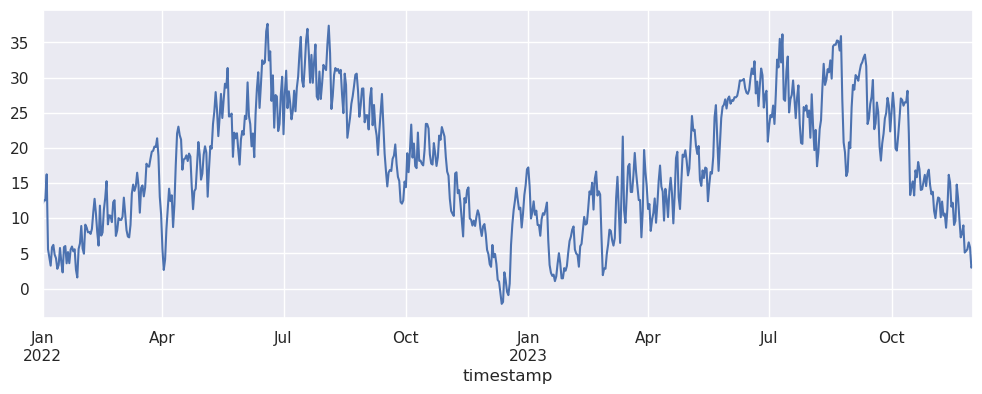

In [106]:
df_meteo['Maximum'].plot(figsize=(12,4));

Autocorrelatie: mate van correlatie van dezelfde variabele tussen successieve tijdsintervallen

    -1 tot 0: negatieve autocorrelatie

    0 tot 1: positieve autocorrelatie

    Informatie over de trend in een set van historische data

Bron: https://corporatefinanceinstitute.com/resources/data-science/autocorrelation/

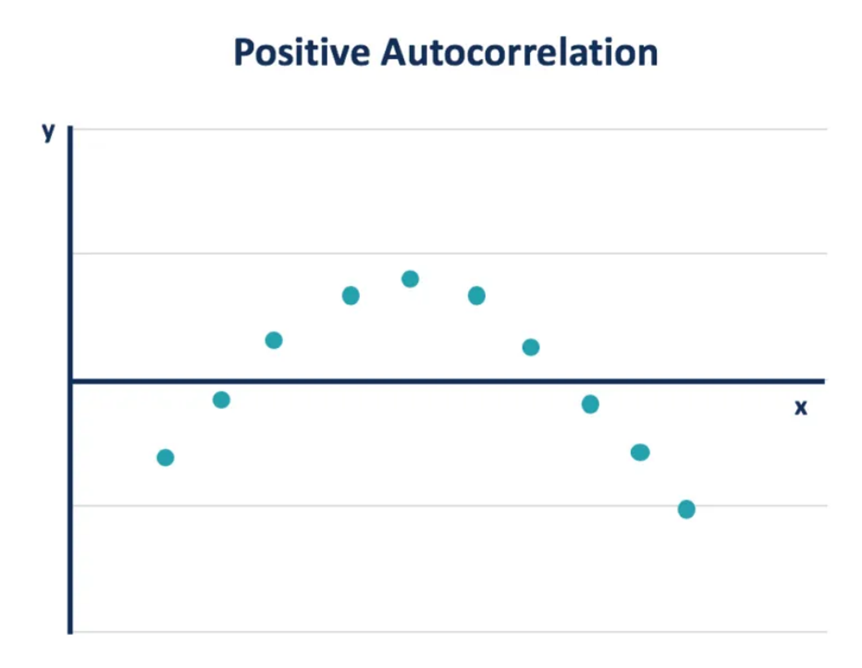

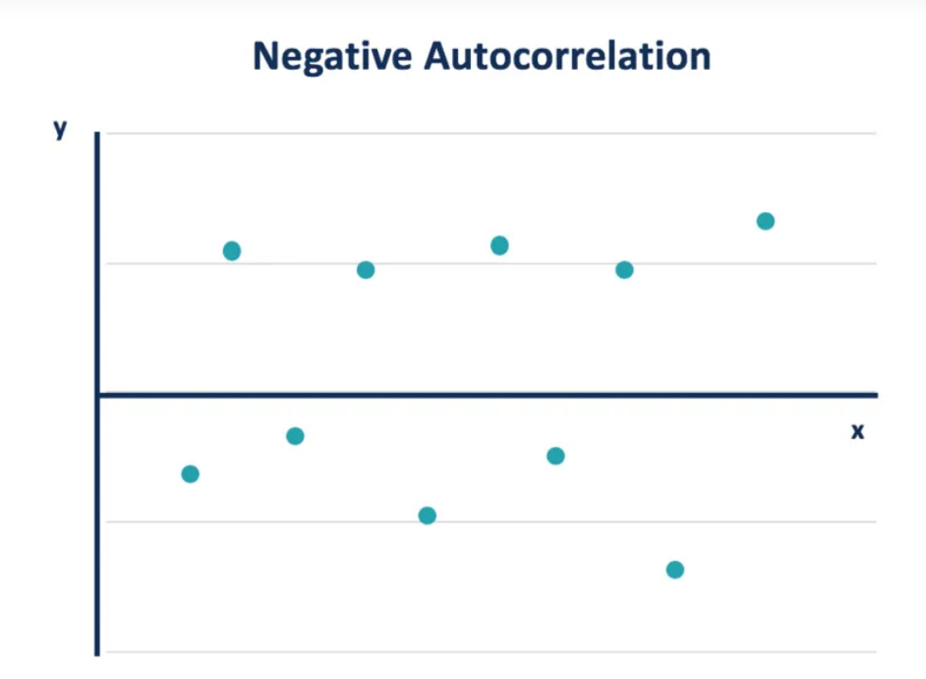

Om autocorrelatie te kunnen bepalen moeten we de data met een tijdsinterval verschuiven. Elke eenheid van verschuiving van een tijdsinterval staat gelijk aan 1 eenheid aan lag.

In [107]:
df_lags = df_meteo.copy()
df_lags.rename({'Maximum': 'Unlagged'}, axis=1, inplace=True)
df_lags = df_lags.drop(columns=['Minimum', 'Mean'])

lags = 10

for i in range(lags):
    if i > 0:
        df_lags['lag_'+str(i)] = df_lags['Unlagged'].shift(i)

Scatter plots van de oorspronkelijke data met de data over een bepaalde lag maakt duidelijk hoe de spreiding vergroot met het oplopen van de lag.

<Axes: xlabel='Unlagged', ylabel='lag_9'>

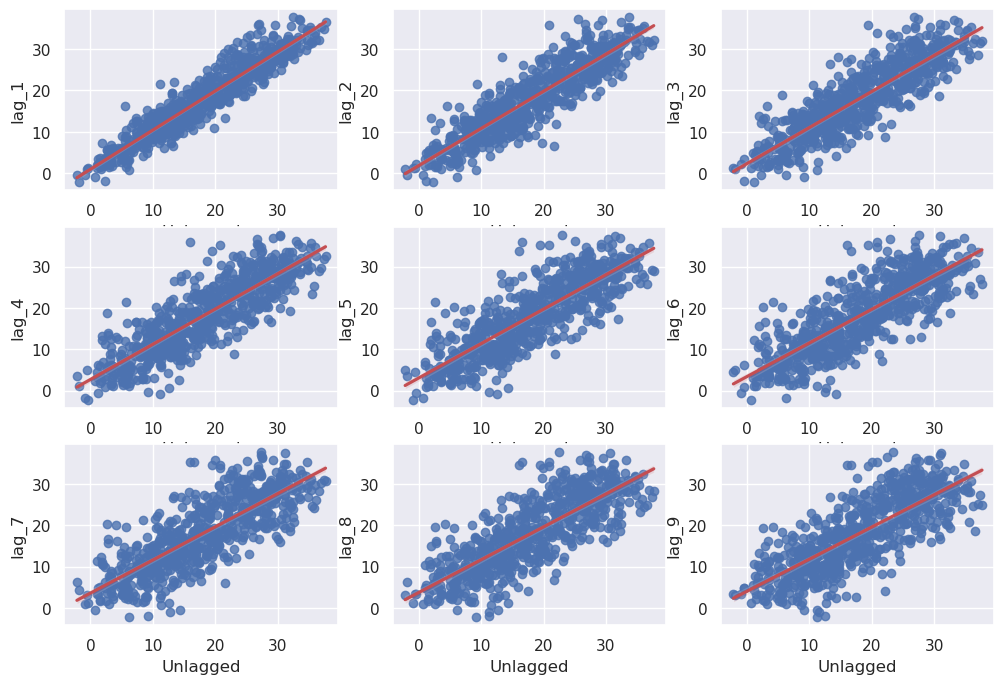

In [108]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=(12,8))
sns.regplot(x = "Unlagged", y = "lag_1", data = df_lags, ax=axes[0,0], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_2", data = df_lags, ax=axes[0,1], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_3", data = df_lags, ax=axes[0,2], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_4", data = df_lags, ax=axes[1,0], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_5", data = df_lags, ax=axes[1,1], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_6", data = df_lags, ax=axes[1,2], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_7", data = df_lags, ax=axes[2,0], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_8", data = df_lags, ax=axes[2,1], line_kws = dict(color = 'r'))
sns.regplot(x = "Unlagged", y = "lag_9", data = df_lags, ax=axes[2,2], line_kws = dict(color = 'r'))

Autocorrelatie geeft de spreiding weer door de correlatie te berekenen over de lagged data.

In [109]:
# Calculating the correlation of column A against all others
corr_matrix = df_lags.corr()["Unlagged"]

<Axes: >

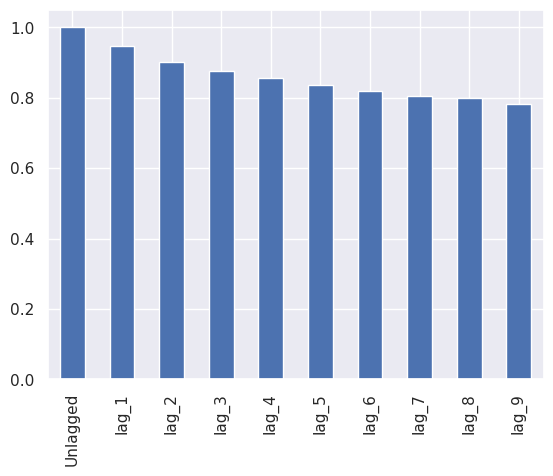

In [110]:
corr_matrix.plot.bar()

Voor tijdsperioden van 1 dag is de autocorrelatie nog behoorlijk hoog. De temperatuur van 9 dagen later laat zich m.a.w. nog behoorlijk goed voorspellen op basis van de temperatuur van vandaag. Dit in verhouding tot de totale spreiding van de meteo data. Wat als de sprongen van de lag groter gemaakt worden?

In [111]:
df_lags = df_meteo.copy()
df_lags.rename({'Maximum': 'Unlagged'}, axis=1, inplace=True)
df_lags = df_lags.drop(columns=['Minimum', 'Mean'])
#df_lags['lag_1'] = df['Unlagged'].shift(1)

lags = 25

for i in range(lags):
    if i > 0:
        df_lags['lag_'+str(10*i)] = df_lags['Unlagged'].shift(10*i)

<Axes: >

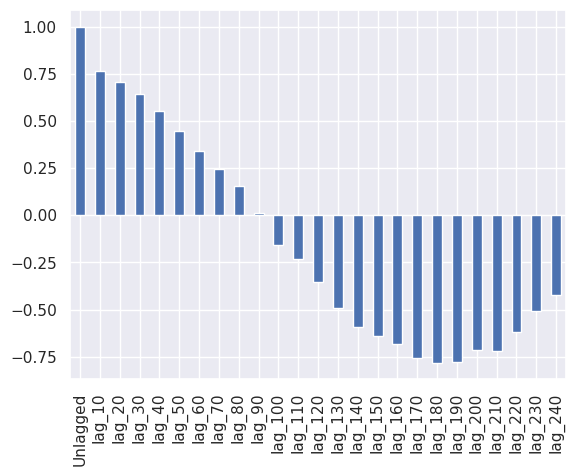

In [112]:
df_lags.corr()["Unlagged"].plot.bar()

#### Autocorrelatie functie van statsmodels

In [113]:
# Autocorrelation plot:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

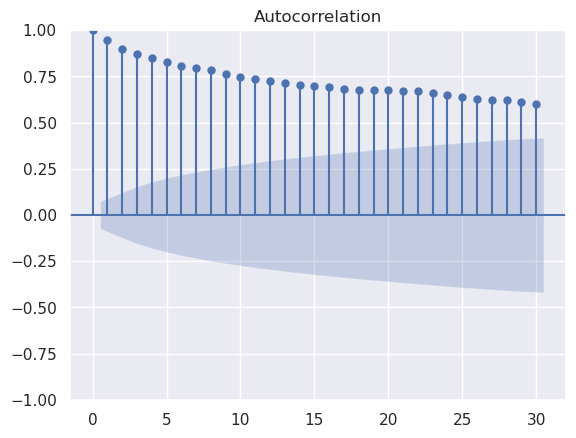

In [114]:
ax = plot_acf(df_meteo['Maximum'], lags=30);

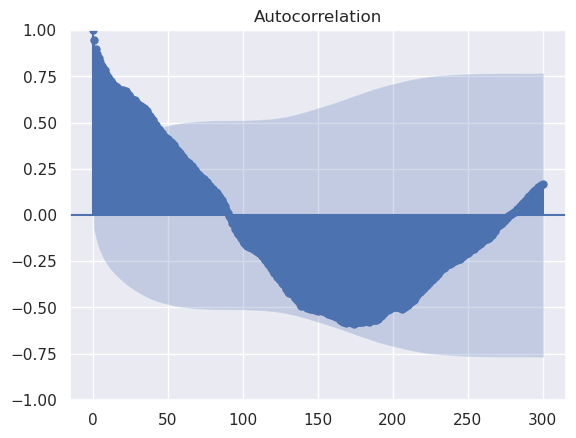

In [115]:
ax = plot_acf(df_meteo['Maximum'], lags=300);

#### Autocorrelatie in Sunspots dataset

Uit dit detail van de residual plot zou ik vermoeden dat er een bijkomende cyclische component is die niet op jaarlijkse schaal maar ongeveer 10-jaarlijks terugkomt. Ik ga de frequentie hiervan na via een autocorrelatie plot:

In [116]:
# Autocorrelation plot:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

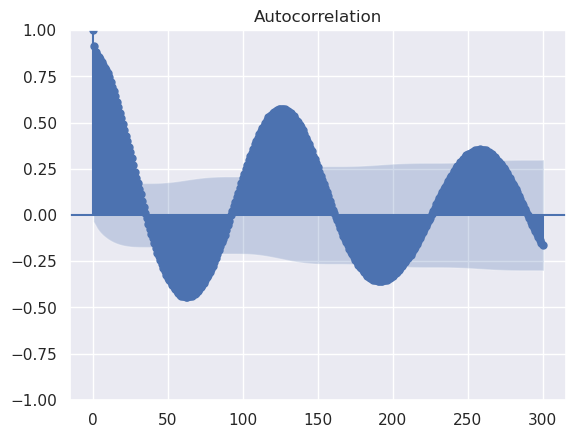

In [117]:
ax = plot_acf(df['Monthly Mean Total Sunspot Number'], lags=300);

We zien op ongeveer 125 en iets voorbij 250 (260?) een piek in de autocorrelatie. De blauwe "schaduwzone" is de 95% CI zone; deze wordt groter in functie van de lag waarde.  Waarden buiten deze zone zijn zeer waarschijnlijk echte correlaties dus er is wel degelijk een terugkerend patroon met een frequentie van ongeveer 130 maanden. 

## Voorspellingstechnieken

Tot nu toe hebben we elke voorspelling even belangrijk gevonden, eenzelfde gewicht gegeven binnen onze voorspelling. We kunnen echter er ook voor kiezen om minder gewicht te geven aan de oudste voorspellingen, en meer gewicht aan de meest recente voorspellingen. Dit kan aan de hand van exponential smoothing.

We kennen drie stappen binnen exponential smoothing:
- Simple exponential smoothing
- Double exponential smoothing (oftewel de Holt methode)
- Triple exponential smoothing

We maken eerst een train- en testset, we splitsen onze huidige dataset op vanaf augustus 2009.

In [118]:
train = df.loc[:'2009-07-31']
test = df.loc['2009-08-01':]

In [119]:
len(train)

3127

In [120]:
start = len(train)
end = len(train) + len(test) - 1

#### Simple Exponential Smoothing

De formule voor simple exponential smoothing is de volgende:

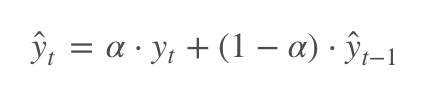

α = de smoothing factor. Hoe kleiner α, hoe groter de invloed van de voorgaande observaties.

Ŷt = de voorspelling

Yt = de observatie

Yt-1 = de vorige observatie

In [121]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12 # 12 maanden per jaar
alpha = 2/(span+1)

model = SimpleExpSmoothing(train['Monthly Mean Total Sunspot Number'])
fitted_SESmodel = model.fit(optimized=True)
#smoothing_level=alpha

df['SES']= fitted_SESmodel.fittedvalues.shift(-1)
#SimpleExpSmoothing(train['Monthly Mean Total Sunspot Number']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Monthly Mean Total Sunspot Number,Sunspot Rolling Mean 5,Sunspot Rolling Mean 10,Rolling Mean 5 PRED,Rolling Mean 10 PRED,EWMA12,EWMA PRED,SES
Date,,,,,,,,
1749-01-31,96.7,NaN,NaN,NaN,NaN,96.700000,NaN,96.700000
1749-02-28,104.3,NaN,NaN,NaN,NaN,100.816667,NaN,100.643485
1749-03-31,116.7,NaN,NaN,NaN,NaN,107.015935,NaN,108.974883
1749-04-30,92.8,NaN,NaN,NaN,NaN,102.528520,NaN,100.582066
1749-05-31,141.7,110.44,NaN,NaN,NaN,113.171271,NaN,121.917322


Berekening: 

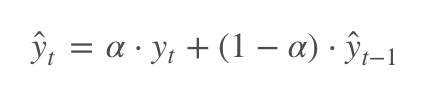
    
Ŷt = 0.15 (alpha) * 104.3 (tweede observatie) + 0.85 (1 - 0.15) * 99.813653 (voorgaande voorspelling)

In [122]:
print(f'Ŷt = {round(alpha,2)} * 104,3 + (1-{round(alpha,2)}) * 99,813653')
Ŷt = alpha * 104.3 + (1-alpha) * 99.813653
Ŷt

Ŷt = 0.15 * 104,3 + (1-0.15) * 99,813653


100.50386023076923

We breiden uit naar een forecast voor de volgende 108 maanden:

In [123]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 108 # 12 maanden per jaar
alpha = 2/(span+1)

model = SimpleExpSmoothing(train['Monthly Mean Total Sunspot Number'])
fitted_model=model.fit()

In [124]:
# alles is 1 positie opgeschoven - terug:
df['SES12'] = fitted_model.fittedvalues.shift(-1)

In [125]:
# forecast 
predictions_SES = fitted_SESmodel.forecast(108)

In [126]:
df['SES120_predictions'] = fitted_SESmodel.forecast(108)
predictions_SES 

2009-08-31    4.902203
2009-09-30    4.902203
2009-10-31    4.902203
2009-11-30    4.902203
2009-12-31    4.902203
                ...   
2018-03-31    4.902203
2018-04-30    4.902203
2018-05-31    4.902203
2018-06-30    4.902203
2018-07-31    4.902203
Freq: M, Length: 108, dtype: float64

<Axes: xlabel='Date'>

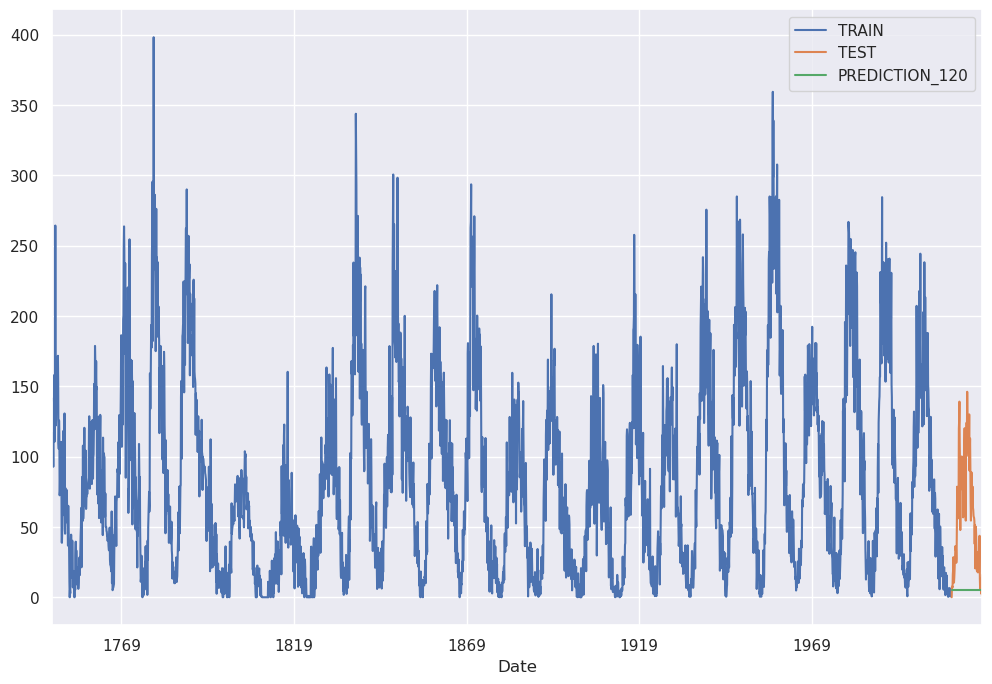

In [127]:
# plotten tov echte data

# echte data:
train['Monthly Mean Total Sunspot Number'].plot(legend=True,label='TRAIN', figsize=(12,8))
test['Monthly Mean Total Sunspot Number'].plot(legend=True, label='TEST')

#test_predictions.plot(legend=True, label='PREDICTION')
predictions_SES.plot(legend=True, label='PREDICTION_120')

In [128]:
## Evaluatie van het SES model
from sklearn.metrics import mean_squared_error, mean_absolute_error
#mean_absolute_error(test['Monthly Mean Total Sunspot Number'], predictions_SES12_120)
mean_absolute_error(test['Monthly Mean Total Sunspot Number'], predictions_SES)

54.95254877119194

In [129]:
# mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_SES12_120)
mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_SES)

4497.211396143182

In [130]:
# np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_SES12_120)) # rmse
np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_SES)) # rmse

67.06125107797484

We zien dat de voorspellingen voor de komende 120 maanden een rechte lijn volgen, omdat de volgende voorspelling altijd afhangt van de laatste voorspelling (Ŷt-1) en de effectieve observatie (Yt). We kunnen dus voorlopig maar één voorspelling maken. We gebruiken de simple exponential smoothing methode vooral om data te voorspellen in een dataset waarbij geen duidelijke trend of seizoensgebondenheid te zien is. We passen de smoothing dus toe rond de trend.

In deze dataset hebben we gezien dat die trend er wel is, dus daar moeten we een oplossing voor vinden. En die is er, uiteraard.

### Double Exponential smoothing (Holt methode)

Bij double exponential smoothing gaan we ervan uit dat de toekomstige richting van de grafiek kan voorspeld worden aan de hand van vorige getoonde trends.

De formule voor Double exponential smoothing is de volgende:

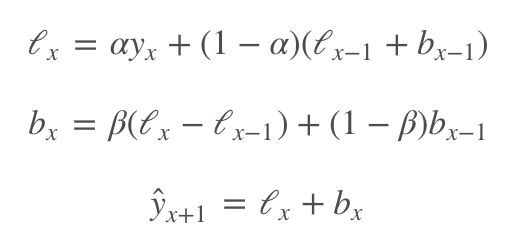

ℓ = intercept

b = helling

α = de smoothing factor. Hoe kleiner α, hoe groter de invloed van de voorgaande observaties.

In [131]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(train['Monthly Mean Total Sunspot Number'], trend='add')
fitted_model=model.fit()

df['DES_add_12'] = fitted_model.fittedvalues.shift(-1)

# DES = double exponential smoothing

In [132]:
# forecast 
predictions_DES12_12 = fitted_model.forecast(12)
predictions_DES12_120 = fitted_model.forecast(108)

<Axes: xlabel='Date'>

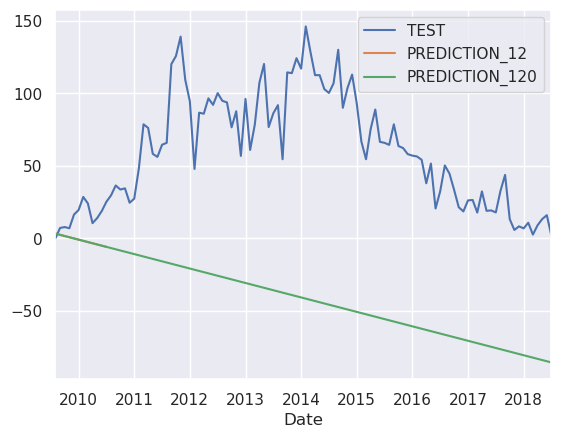

In [133]:
# plotten tov echte data

# echte data:
#train['Monthly Mean Total Sunspot Number'].plot(legend=True,label='TRAIN', figsize=(12,8))
test['Monthly Mean Total Sunspot Number'].plot(legend=True, label='TEST')

# test_predictions.plot(legend=True, label='PREDICTION')
predictions_DES12_12.plot(legend=True, label='PREDICTION_12')
predictions_DES12_120.plot(legend=True, label='PREDICTION_120')

In [134]:
# Evaluatie van het DES model
mean_absolute_error(test['Monthly Mean Total Sunspot Number'], predictions_DES12_120)

100.97519166738564

In [135]:
mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_DES12_120)

12003.852966554463

In [136]:
np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_DES12_120)) # rmse

109.5620963953979

We zien nu dat de rechte al niet meer horizontaal ligt, en een helling heeft gekregen.

In deze dataset hebben we ook gezien dat er wel een seasonality is, en ook daar is een oplossing voor gevonden.

### Triple Exponential smoothing (Holt-Winters)

#### Dit wilt ook wel zeggen dat we deze methode niet gebruiken indien er geen seasonality is in een dataset!

Het seasonal component zal herhalingen rond de intercept en trend verklaren, en zal gespecifieerd worden door de lengte van een season (= een periode waarin die herhalingen voorkomen). Elk season bestaat uit seanonal components, bijvoorbeeld: een week is 7 dagen lang, dus bestaat uit 7 seasonal components.

De bovenstaande formule wordt nog verder uitgebreid, en ziet er nu zo uit:

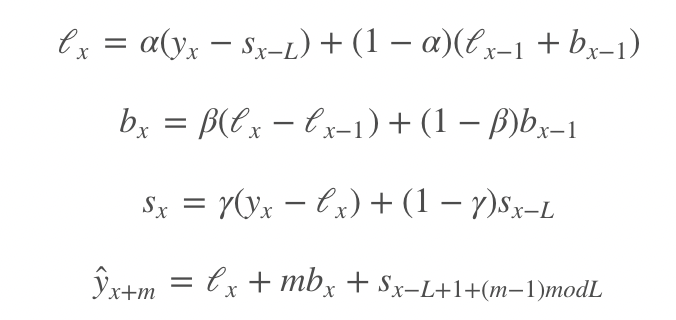

In [148]:
model = ExponentialSmoothing(train['Monthly Mean Total Sunspot Number'], trend='add', seasonal='add', seasonal_periods=108)
fitted_model = model.fit()
df['TES_add_12'] = fitted_model.fittedvalues

# TES = triple exponential smoothing

In [149]:
# forecast 
predictions_TES12_12 = fitted_model.forecast(12)
predictions_TES12_120 = fitted_model.forecast(108)
df['TES120_predictions'] = predictions_TES12_120

In [150]:
predictions_TES12_120

2009-08-31    -0.475699
2009-09-30   -13.869421
2009-10-31   -10.941947
2009-11-30   -13.325310
2009-12-31    -4.554069
                ...    
2018-03-31     2.852769
2018-04-30    -4.411576
2018-05-31    -6.672707
2018-06-30     8.661570
2018-07-31    10.160391
Freq: M, Length: 108, dtype: float64

<Axes: xlabel='Date'>

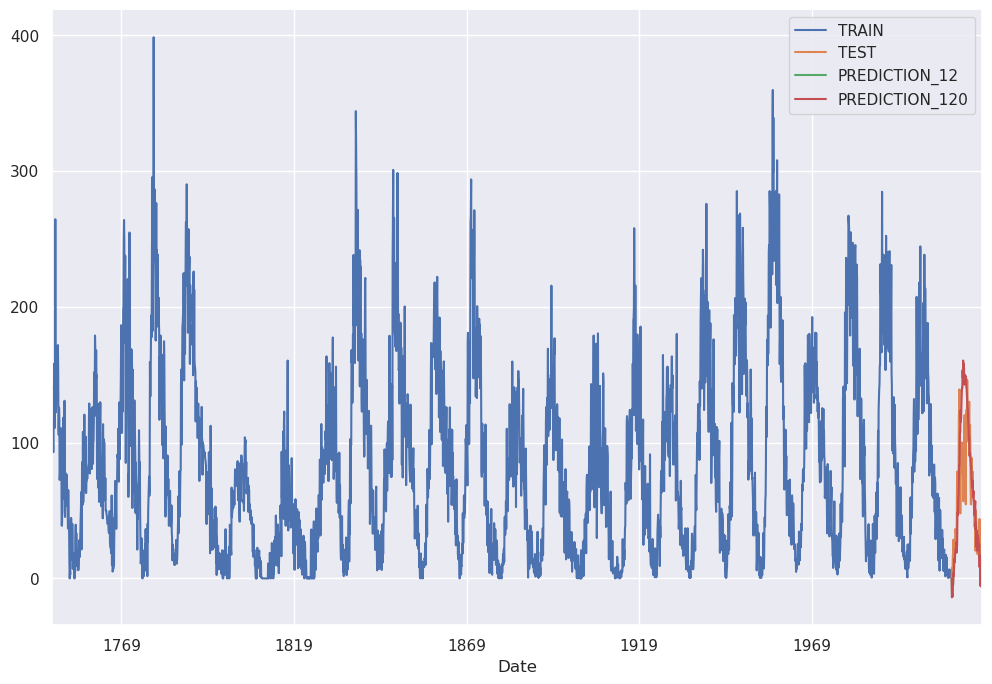

In [151]:
# plotten tov echte data

# echte data:
train['Monthly Mean Total Sunspot Number'].plot(legend=True,label='TRAIN', figsize=(12,8))
test['Monthly Mean Total Sunspot Number'].plot(legend=True, label='TEST')

# test_predictions.plot(legend=True, label='PREDICTION')
predictions_TES12_12.plot(legend=True, label='PREDICTION_12')
predictions_TES12_120.plot(legend=True, label='PREDICTION_120')

<Axes: xlabel='Date'>

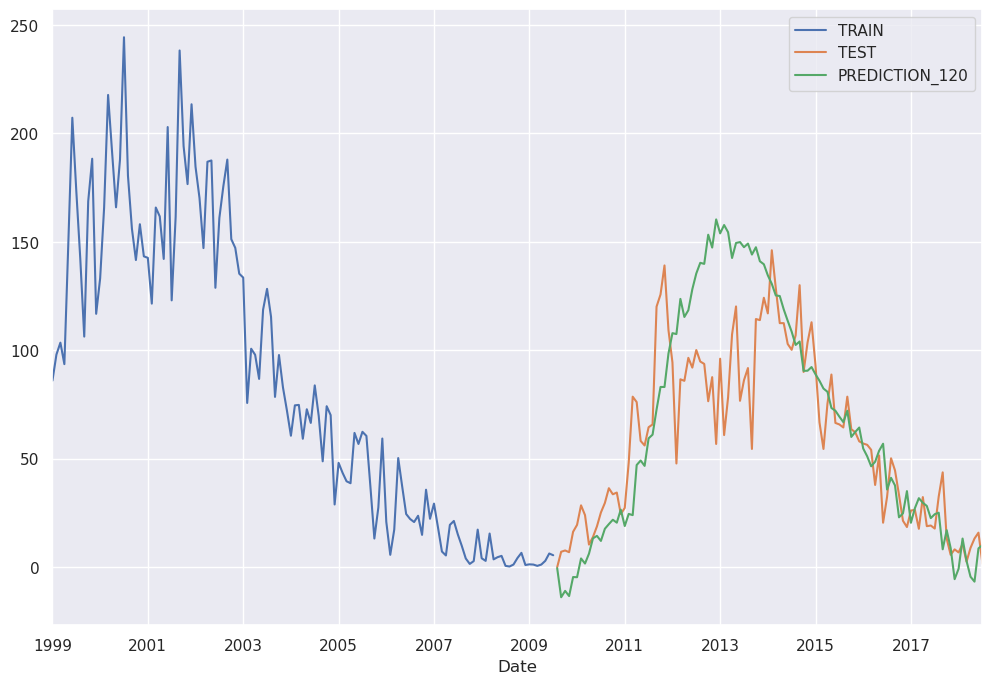

In [152]:
# plotten tov echte data

# echte data:
train['Monthly Mean Total Sunspot Number']['1999-01-01':].plot(legend=True,label='TRAIN', figsize=(12,8))
test['Monthly Mean Total Sunspot Number'].plot(legend=True, label='TEST')

# test_predictions.plot(legend=True, label='PREDICTION')
#predictions_TES12_12.plot(legend=True, label='PREDICTION_12')
predictions_TES12_120.plot(legend=True, label='PREDICTION_120')

We zien nu dat de rechte met helling die we kenden uit het vorige model, niet meer recht is, maar nu dus ook een trend volgt, zoals onze trainset.

In [153]:
# Evaluatie van het TES model - MAE - lange termijn (108 maanden) 
mean_absolute_error(test['Monthly Mean Total Sunspot Number'], predictions_TES12_120)

20.99452787596044

In [154]:
# Evaluatie van het TES model - MAE - korte termijn (24 maanden)
mean_absolute_error(test['Monthly Mean Total Sunspot Number'].loc[:'2011-08-30'], predictions_TES12_120.loc['2009-08-01':'2011-08-30'])

15.406806737107438

In [155]:
# Evaluatie van het TES model - lange termijn: MSE (108 maanden) 
mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_TES12_120)

938.1716694273322

In [156]:
# Evaluatie van het TES model - MSE - korte termijn (24 maanden)
mean_squared_error(test['Monthly Mean Total Sunspot Number'].loc[:'2011-08-30'], predictions_TES12_120.loc['2009-08-01':'2011-08-30'])

371.8578798417345

In [157]:
# Evaluatie van het TES model - lange termijn: RMSE (108 maanden)
np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], predictions_DES12_120)) # rmse

109.5620963953979

In [158]:
# Evaluatie van het TES model - korte termijn: RMSE (24 maanden)
np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'].loc[:'2011-08-30'], predictions_DES12_120.loc['2009-08-01':'2011-08-30'])) # rmse

46.01866497125513

## Autoregression (AR) model

<Axes: xlabel='Date'>

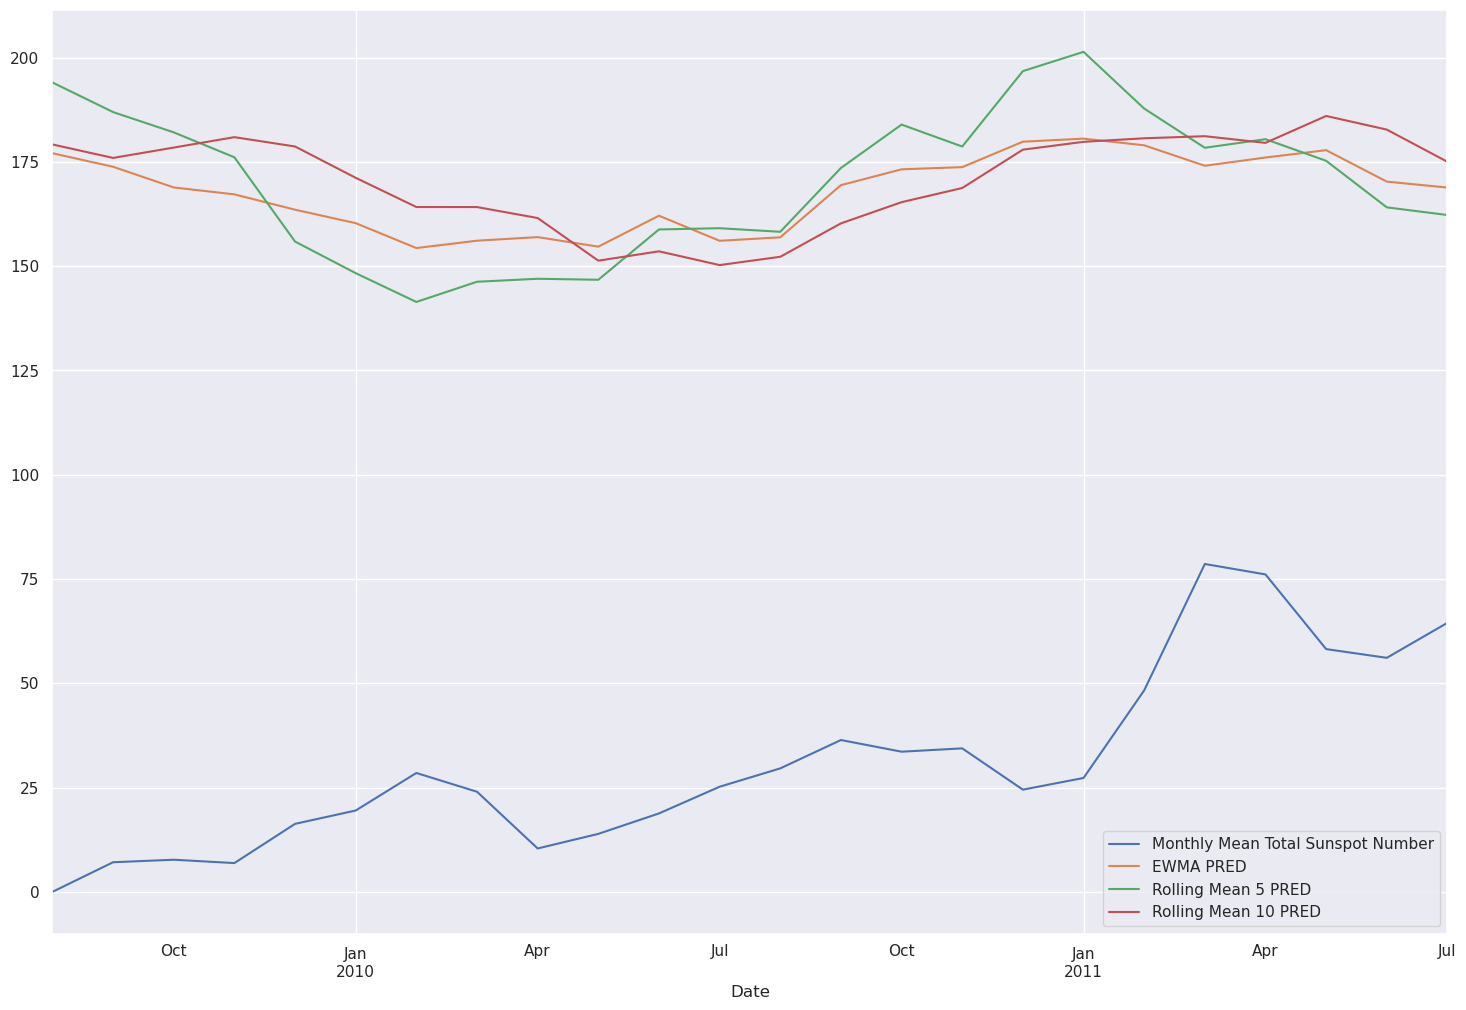

In [85]:
# plot van een detail van de laatste 2 jaar:
# df[['Monthly Mean Total Sunspot Number','TES120_predictions', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED', 'AR PRED']].loc['2009-08-01':'2011-08-01'].plot(figsize=(18,12), legend='True')df[['Monthly Mean Total Sunspot Number','TES120_predictions', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED', 'AR PRED']].loc['2009-08-01':'2011-08-01'].plot(figsize=(18,12), legend='True')
df[['Monthly Mean Total Sunspot Number', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED']].loc['2009-08-01':'2011-08-01'].plot(figsize=(18,12), legend='True')

Zowel een voortschrijdend gemiddelde van 5 als van 10 lijkt bruikbaar.  We gebruiken nu beiden om een voorspelling van een cyclus van 11 jaar te doen:


In [86]:
df['Predict Rolling Mean 5'] = df['Monthly Mean Total Sunspot Number'].rolling(window=5).mean()
df['Predict Rolling Mean 10'] = df['Monthly Mean Total Sunspot Number'].rolling(window=10).mean()

In [87]:
# from statsmodels.tsa.ar_model import AR,ARResults

from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(train['Monthly Mean Total Sunspot Number'], lags=500)
ARfit = model.fit()

In [88]:
# AR model
# model = AR(train['Monthly Mean Total Sunspot Number'])
# ARfit = model.fit(maxlag=500)

In [89]:
ARfit.params

const                                     6.582315
Monthly Mean Total Sunspot Number.L1      0.521526
Monthly Mean Total Sunspot Number.L2      0.088824
Monthly Mean Total Sunspot Number.L3      0.059948
Monthly Mean Total Sunspot Number.L4      0.096928
                                            ...   
Monthly Mean Total Sunspot Number.L496   -0.002532
Monthly Mean Total Sunspot Number.L497   -0.010694
Monthly Mean Total Sunspot Number.L498    0.023440
Monthly Mean Total Sunspot Number.L499   -0.018024
Monthly Mean Total Sunspot Number.L500    0.011075
Length: 501, dtype: float64

In [90]:
predictionsAR = ARfit.predict(start,end)
df['AR PRED'] = predictionsAR

In [91]:
mean_absolute_error(test['Monthly Mean Total Sunspot Number'], df['AR PRED'].loc['2009-08-01':])

23.645368656625642

In [92]:
mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['AR PRED'].loc['2009-08-01':])

908.5971227442884

In [93]:
np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'], df['AR PRED'].loc['2009-08-01':])) # rmse

30.14294482535322

<Axes: xlabel='Date'>

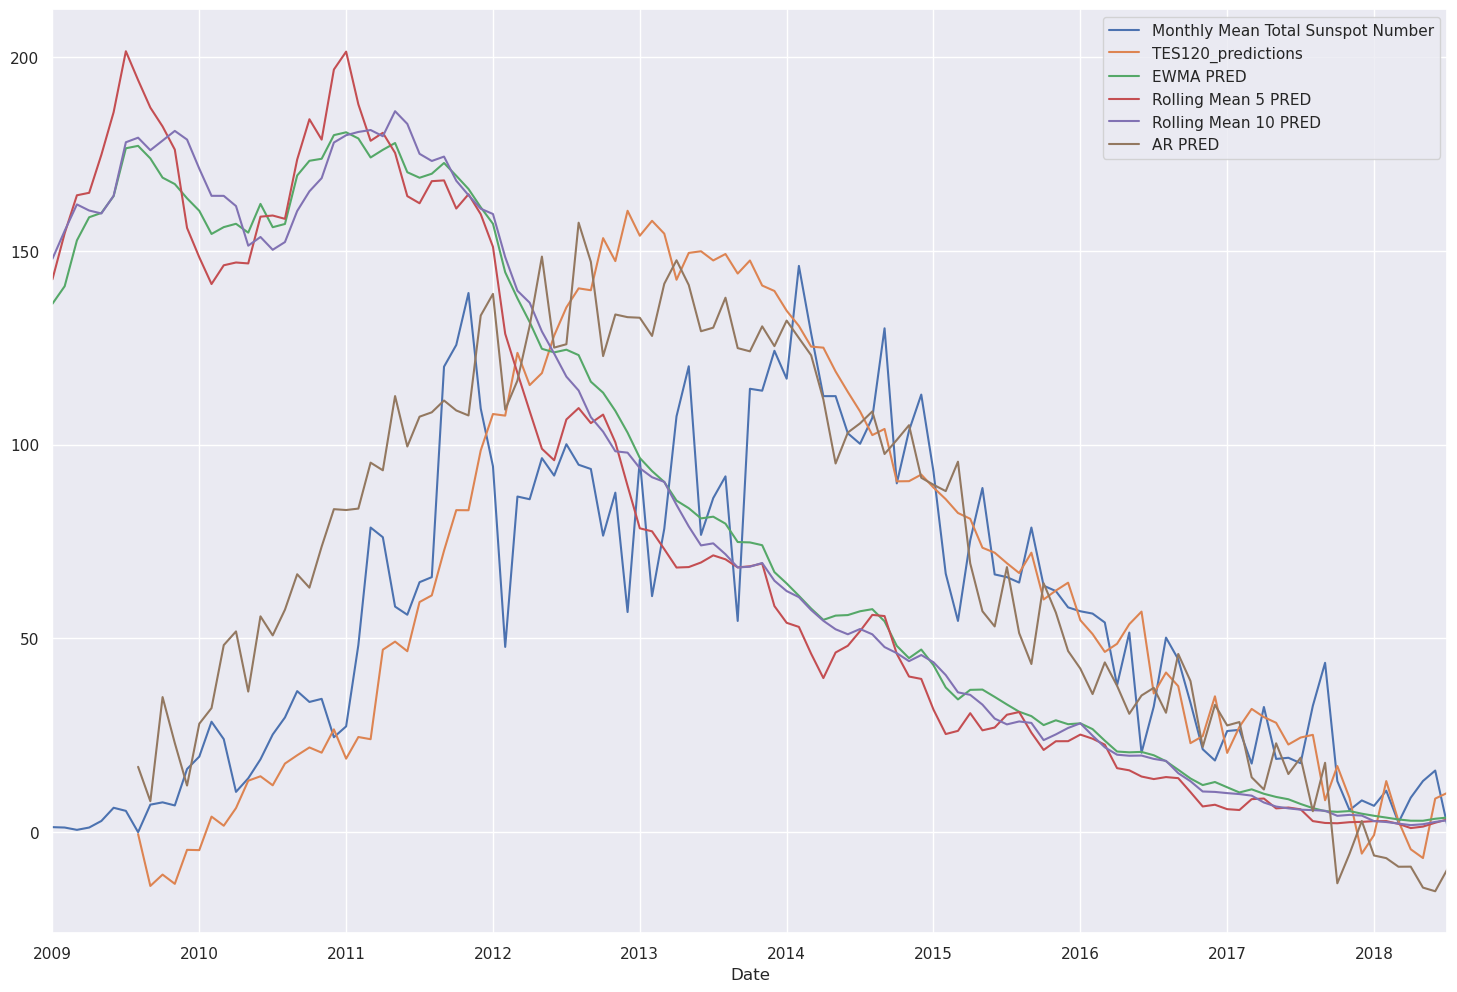

In [94]:
df[['Monthly Mean Total Sunspot Number','TES120_predictions', 'EWMA PRED','Rolling Mean 5 PRED', 'Rolling Mean 10 PRED', 'AR PRED']].loc['2009-01-01':].plot(figsize=(18,12), legend='True')

In [95]:
## AR geeft de beste predictie - weergave van enkel het AR model:

<Axes: xlabel='Date'>

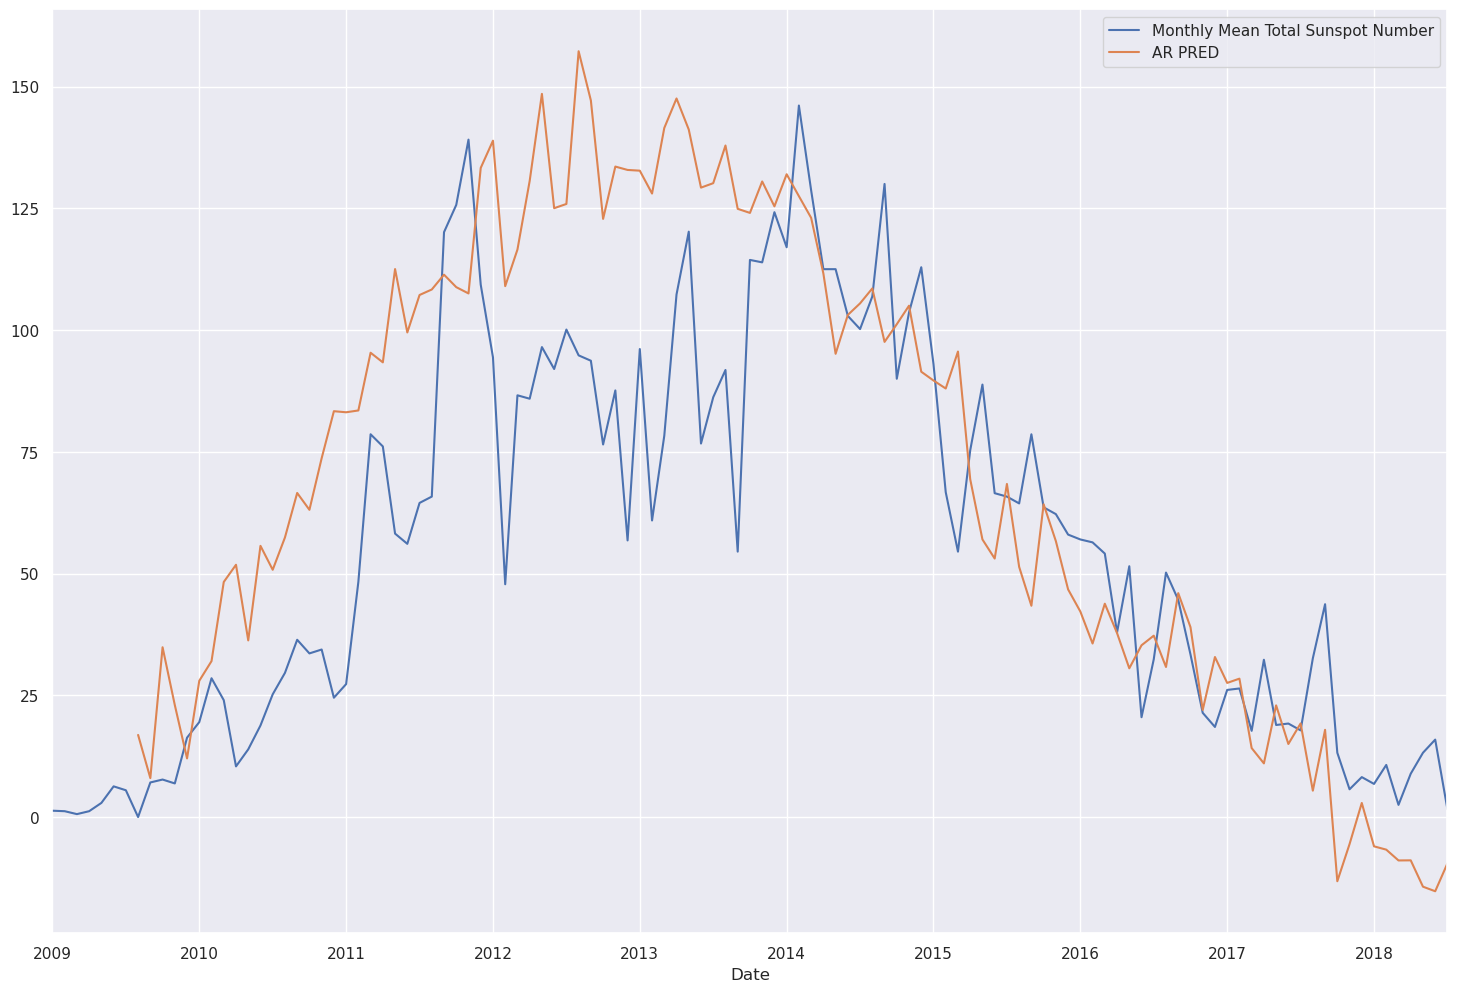

In [96]:
df[['Monthly Mean Total Sunspot Number','AR PRED']].loc['2009-01-01':].plot(figsize=(18,12), legend='True')

In [97]:
# Evaluatie van het AR model - korte termijn: RMSE (24 maanden)
np.sqrt(mean_squared_error(test['Monthly Mean Total Sunspot Number'].loc[:'2011-08-30'], predictionsAR.loc['2009-08-01':'2011-08-30'])) # rmse

32.498556047916885